<a href="https://colab.research.google.com/github/dahouda2pro/Deep-Neural-Network-Using-BO/blob/main/Bayesian_Opt2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Install GPy, GPyOpt
!pip install GPy==1.9.8
!pip install GPyOpt==1.2.1
!pip install tensorflow-addons
import tensorflow as tf
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras as K
import tensorflow_addons as tfa
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import GPy
import GPyOpt
from GPyOpt.methods import BayesianOptimization



import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from math import floor
from sklearn.metrics import make_scorer, accuracy_score

from sklearn.model_selection import StratifiedKFold, KFold
from keras.layers import LeakyReLU
LeakyReLU = LeakyReLU(alpha=0.1)
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 989 kB 6.6 MB/s 
     |████████████████████████████████| 71 kB 10.0 MB/s 
  Created wheel for GPy: filename=GPy-1.9.8-cp37-cp37m-linux_x86_64.whl size=2619378 sha256=9fff0b9c6d80dca09951540f0b45e390489daf8df7e0931cd7480b08596de0fa
  Stored in directory: /root/.cache/pip/wheels/23/6d/58/90d8e44f8fd9f442de81992a427a5947a6e5f7b78cd65acd9a
  Created wheel for paramz: filename=paramz-0.9.5-py3-none-any.whl size=102566 sha256=ab9aef593fbd6f76f047cbb9f8e97f57587d929b7309dd818f397f2047acef98
  Stored in directory: /root/.cache/pip/wheels/c8/95/f5/ce28482da28162e6028c4b3a32c41d147395825b3cd62bc810
Successfully built GPy paramz
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 46 kB 3.2 MB/s 
  Created wheel for GPyOpt: filename=GPyOpt-1.2.1-py3-none-any.whl size=73655 sh

In [3]:
!python3 --version
#Python 3.6.9
print(tf.__version__)
#2.3.0
print(K.__version__)
#2.4.0
print(np.__version__)
#1.18.5
#print(matplotlib.__version__)
#3.2.2
print(GPy.__version__)
#1.9.8
print(GPyOpt.__version__)
#1.2.1

Python 3.7.15
2.9.2
2.9.0
1.21.6
1.9.8
1.2.1


In [4]:
''' def preprocess_data(X, Y):
    """
    function that pre-processes the CIFAR10 dataset as per
    densenet model requirements for input images
    labels are one-hot encoded
    """
    X = K.applications.densenet.preprocess_input(X)
    Y = K.utils.to_categorical(Y)
    return X, Y '''

' def preprocess_data(X, Y):\n    """\n    function that pre-processes the CIFAR10 dataset as per\n    densenet model requirements for input images\n    labels are one-hot encoded\n    """\n    X = K.applications.densenet.preprocess_input(X)\n    Y = K.utils.to_categorical(Y)\n    return X, Y '

In [5]:

# load the Cifar10 dataset, 50,000 training images and 10,000 test images (here used as validation data)
#(x_train, y_train), (x_test, y_test) = K.datasets.cifar100.load_data()
#(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# preprocess the data using the application's preprocess_input method and convert the labels to one-hot encodings
#x_train, y_train = preprocess_data(x_train, y_train)
#x_test, y_test = preprocess_data(x_test, y_test)



num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

169001437/169001437 [==============================] - 3s 0us/step
x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


In [6]:
input_tensor = K.Input(shape=(32, 32, 3))
# resize images to the image size upon which the network was pre-trained
resized_images = K.layers.Lambda(lambda image: tf.image.resize(image, (224, 224)))(input_tensor)
base_model = K.applications.DenseNet201(include_top=False,
                                        weights='imagenet',
                                        input_tensor=resized_images,
                                        input_shape=(224, 224, 3),
                                        pooling='max',
                                        classes=num_classes)
output = base_model.layers[-1].output
base_model = K.models.Model(inputs=input_tensor, outputs=output)

74836368/74836368 [==============================] - 1s 0us/step


In [7]:
# using the training data
train_datagen = K.preprocessing.image.ImageDataGenerator()
train_generator = train_datagen.flow(x_train,
                                     y_train,
                                     batch_size=32,
                                     shuffle=False)
features_train = base_model.predict(train_generator)
# repeat the same operation with the test data (here used for validation)
val_datagen = K.preprocessing.image.ImageDataGenerator()
val_generator = val_datagen.flow(x_test,
                                 y_test,
                                 batch_size=32,
                                 shuffle=False)
features_valid = base_model.predict(val_generator)

313/313 [==============================] - 42s 133ms/step


In [8]:
def build_model(units=256, learning_rate=1e-4, l2=1e-2, activation=2, rate=0.5):
  """function that builds a model for the head classifier"""
  # weights are initialized as per the he et al. method
  initializer = K.initializers.he_normal()
  input_tensor = K.Input(shape=features_train.shape[1])
  activation_dict = {1: 'relu', 2: 'elu', 3: 'tanh', 4: 'sigmoid', 5: 'softplus'}
#activation_dict = {1: 'relu', 2: 'elu', 3: 'tanh', 4: 'sigmoid', 5: 'softplus', 6: 'softsign', 7: 'selu'}
  layer = K.layers.Dense(units=units,
                         activation=activation_dict[activation],
                         kernel_initializer=initializer,
                        kernel_regularizer=K.regularizers.l2(l2=l2))
  output = layer(input_tensor)
  dropout = K.layers.Dropout(rate)
  output = dropout(output)
  softmax = K.layers.Dense(units=1,
                           activation='softmax',
                           kernel_initializer=initializer,
                        kernel_regularizer=K.regularizers.l2(l2=l2))
  output = softmax(output)
  model = K.models.Model(inputs=input_tensor, outputs=output)
  # compile the densely-connected head classifier (here, "model")
  model.compile(
           optimizer=K.optimizers.Adam(learning_rate=learning_rate),
           loss='categorical_crossentropy',
           metrics=['accuracy'])
  # Define some callback functions to be used by the model during training
  # reduce learning rate when val_accuracy has stopped improving
  lr_reduce = K.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                            factor=0.6,
                                            patience=2,
                                            verbose=1,
                                            mode='max',
                                            min_lr=1e-7)
  # stop training when val_accuracy has stopped improving
  early_stop = K.callbacks.EarlyStopping(monitor='val_accuracy',
                                         patience=3,
                                         verbose=1,
                                         mode='max')
  # callback to save the Keras model and (best) weights obtained on an epoch basis
  checkpoint = K.callbacks.ModelCheckpoint('cifar10.h5',
                                           monitor='val_accuracy',
                                           verbose=1,
                                           save_weights_only=False,
                                           save_best_only=True,
                                           mode='max',
                                           save_freq='epoch')
  return model, lr_reduce, early_stop, checkpoint

In [9]:
def fit_model(model, lr_reduce, early_stop, checkpoint):
  """function that trains the head classifier"""
  history = model.fit(features_train, y_train,
                      batch_size=32,
                      epochs=5,
                      verbose=1,
                      callbacks=[lr_reduce, early_stop, checkpoint],
                      validation_data=(features_valid, y_test),
                      shuffle=True)
  return history

In [10]:
def evaluate_model(model):
  """function that evaluates the head classifier"""
  evaluation = model.evaluate(features_valid, y_test)
  return evaluation



Hyperparameters: [[2.56e+02 1.00e-05 1.00e-01 3.00e+00 2.50e-01]]
Epoch 1/5
1563/1563 [==============================] - ETA: 0s - loss: 43.0602 - accuracy: 0.0100
Epoch 1: val_accuracy improved from -inf to 0.01000, saving model to cifar10.h5
1563/1563 [==============================] - 7s 4ms/step - loss: 43.0602 - accuracy: 0.0100 - val_loss: 36.0534 - val_accuracy: 0.0100 - lr: 1.0000e-05
Epoch 2/5
1556/1563 [============================>.] - ETA: 0s - loss: 31.1805 - accuracy: 0.0100
Epoch 2: val_accuracy did not improve from 0.01000
1563/1563 [==============================] - 5s 3ms/step - loss: 31.1633 - accuracy: 0.0100 - val_loss: 27.0327 - val_accuracy: 0.0100 - lr: 1.0000e-05
Epoch 3/5
1556/1563 [============================>.] - ETA: 0s - loss: 24.0380 - accuracy: 0.0100
Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.01000
1563/1563 [==============================] - 5s 4ms/step - loss: 24.0271 - a

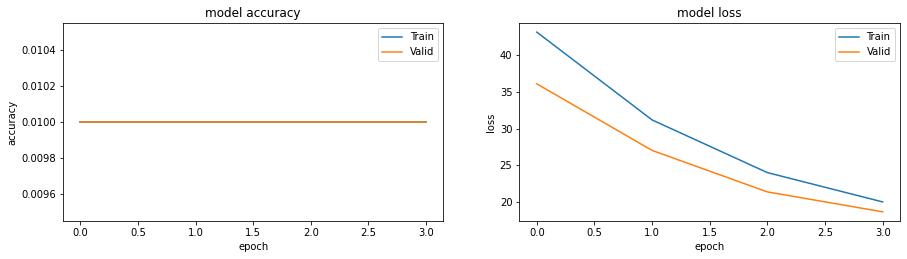


Hyperparameters: [[2.56e+02 1.00e-04 1.00e-03 4.00e+00 5.00e-01]]
313/313 [==============================] - 1s 3ms/step - loss: 18.7138 - accuracy: 0.0100
Epoch 1/5
1557/1563 [============================>.] - ETA: 0s - loss: 0.3268 - accuracy: 0.0100
Epoch 1: val_accuracy improved from -inf to 0.01000, saving model to cifar10.h5
1563/1563 [==============================] - 6s 4ms/step - loss: 0.3265 - accuracy: 0.0100 - val_loss: 0.2642 - val_accuracy: 0.0100 - lr: 1.0000e-04
Epoch 2/5
1555/1563 [============================>.] - ETA: 0s - loss: 0.2502 - accuracy: 0.0100
Epoch 2: val_accuracy did not improve from 0.01000
1563/1563 [==============================] - 6s 4ms/step - loss: 0.2502 - accuracy: 0.0100 - val_loss: 0.2403 - val_accuracy: 0.0100 - lr: 1.0000e-04
Epoch 3/5
1553/1563 [============================>.] - ETA: 0s - loss: 0.2344 - accuracy: 0.0100
Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0

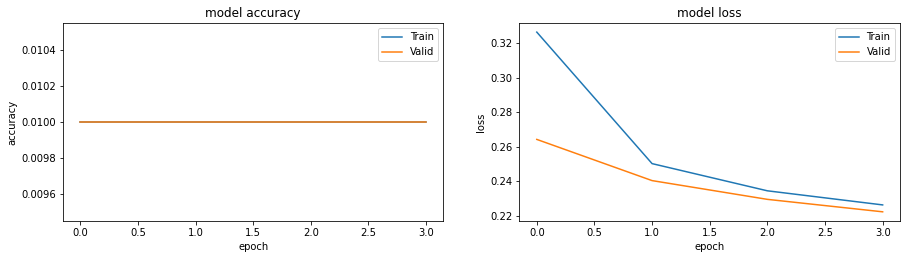


Hyperparameters: [[2.56e+02 1.00e-06 1.00e-01 4.00e+00 5.00e-01]]
313/313 [==============================] - 1s 3ms/step - loss: 18.7138 - accuracy: 0.0100
Epoch 1/5
1560/1563 [============================>.] - ETA: 0s - loss: 50.3342 - accuracy: 0.0100
Epoch 1: val_accuracy improved from -inf to 0.01000, saving model to cifar10.h5
1563/1563 [==============================] - 7s 4ms/step - loss: 50.3325 - accuracy: 0.0100 - val_loss: 49.2920 - val_accuracy: 0.0100 - lr: 1.0000e-06
Epoch 2/5
1560/1563 [============================>.] - ETA: 0s - loss: 48.3013 - accuracy: 0.0100
Epoch 2: val_accuracy did not improve from 0.01000
1563/1563 [==============================] - 6s 4ms/step - loss: 48.2997 - accuracy: 0.0100 - val_loss: 47.3203 - val_accuracy: 0.0100 - lr: 1.0000e-06
Epoch 3/5
1551/1563 [============================>.] - ETA: 0s - loss: 46.3656 - accuracy: 0.0100
Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve

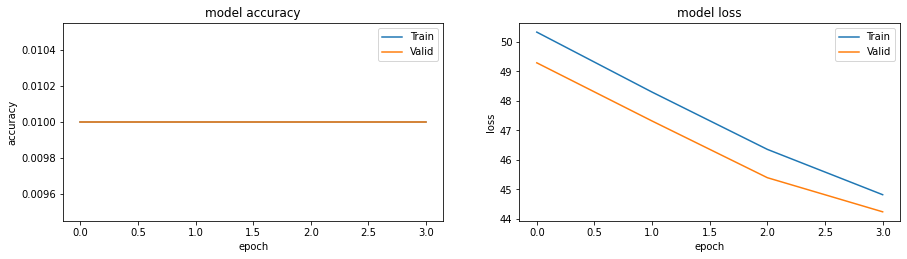


Hyperparameters: [[2.56e+02 1.00e-04 1.00e-02 4.00e+00 2.50e-01]]
313/313 [==============================] - 1s 3ms/step - loss: 18.7138 - accuracy: 0.0100
Epoch 1/5
1562/1563 [============================>.] - ETA: 0s - loss: 2.6018 - accuracy: 0.0100
Epoch 1: val_accuracy improved from -inf to 0.01000, saving model to cifar10.h5
1563/1563 [==============================] - 8s 5ms/step - loss: 2.6016 - accuracy: 0.0100 - val_loss: 1.9113 - val_accuracy: 0.0100 - lr: 1.0000e-04
Epoch 2/5
1549/1563 [============================>.] - ETA: 0s - loss: 1.6782 - accuracy: 0.0100
Epoch 2: val_accuracy did not improve from 0.01000
1563/1563 [==============================] - 6s 4ms/step - loss: 1.6765 - accuracy: 0.0100 - val_loss: 1.4767 - val_accuracy: 0.0100 - lr: 1.0000e-04
Epoch 3/5
1556/1563 [============================>.] - ETA: 0s - loss: 1.3347 - accuracy: 0.0100
Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0

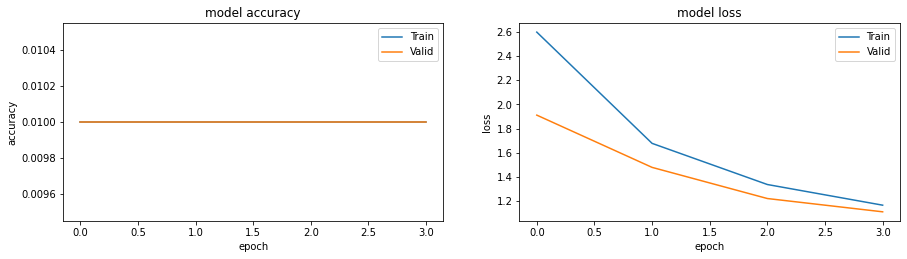


Hyperparameters: [[1.28e+02 1.00e-06 1.00e-03 2.00e+00 7.50e-01]]
313/313 [==============================] - 1s 3ms/step - loss: 18.7138 - accuracy: 0.0100
Epoch 1/5
1552/1563 [============================>.] - ETA: 0s - loss: 0.2574 - accuracy: 0.0100
Epoch 1: val_accuracy improved from -inf to 0.01000, saving model to cifar10.h5
1563/1563 [==============================] - 7s 4ms/step - loss: 0.2574 - accuracy: 0.0100 - val_loss: 0.2569 - val_accuracy: 0.0100 - lr: 1.0000e-06
Epoch 2/5
1547/1563 [============================>.] - ETA: 0s - loss: 0.2565 - accuracy: 0.0101
Epoch 2: val_accuracy did not improve from 0.01000
1563/1563 [==============================] - 6s 4ms/step - loss: 0.2565 - accuracy: 0.0100 - val_loss: 0.2563 - val_accuracy: 0.0100 - lr: 1.0000e-06
Epoch 3/5
1552/1563 [============================>.] - ETA: 0s - loss: 0.2562 - accuracy: 0.0100
Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0

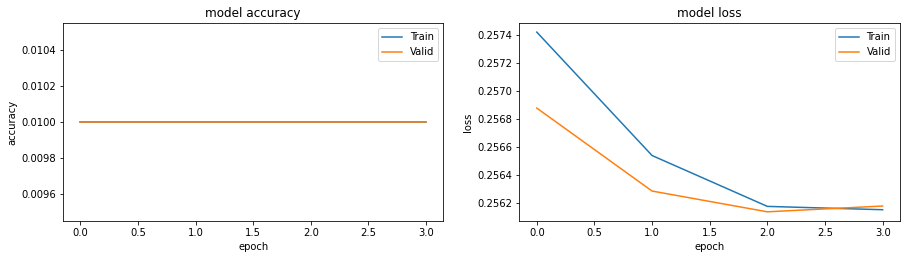




Hyperparameters: [[6.4e+01 1.0e-06 1.0e-01 4.0e+00 7.5e-01]]
313/313 [==============================] - 1s 3ms/step - loss: 18.7138 - accuracy: 0.0100
Epoch 1/5
1559/1563 [============================>.] - ETA: 0s - loss: 12.6462 - accuracy: 0.0100
Epoch 1: val_accuracy improved from -inf to 0.01000, saving model to cifar10.h5
1563/1563 [==============================] - 7s 4ms/step - loss: 12.6456 - accuracy: 0.0100 - val_loss: 12.4052 - val_accuracy: 0.0100 - lr: 1.0000e-06
Epoch 2/5
1561/1563 [============================>.] - ETA: 0s - loss: 12.1757 - accuracy: 0.0100
Epoch 2: val_accuracy did not improve from 0.01000
1563/1563 [==============================] - 6s 4ms/step - loss: 12.1755 - accuracy: 0.0100 - val_loss: 11.9487 - val_accuracy: 0.0100 - lr: 1.0000e-06
Epoch 3/5
1561/1563 [============================>.] - ETA: 0s - loss: 11.7270 - accuracy: 0.0100
Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve fr

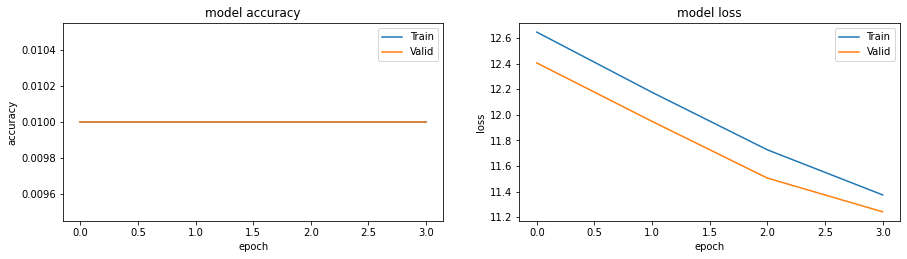


Hyperparameters: [[3.2e+01 1.0e-04 1.0e-01 4.0e+00 7.5e-01]]
313/313 [==============================] - 1s 3ms/step - loss: 18.7138 - accuracy: 0.0100
Epoch 1/5
1557/1563 [============================>.] - ETA: 0s - loss: 2.9978 - accuracy: 0.0100
Epoch 1: val_accuracy improved from -inf to 0.01000, saving model to cifar10.h5
1563/1563 [==============================] - 6s 4ms/step - loss: 2.9945 - accuracy: 0.0100 - val_loss: 2.0378 - val_accuracy: 0.0100 - lr: 1.0000e-04
Epoch 2/5
1552/1563 [============================>.] - ETA: 0s - loss: 1.7619 - accuracy: 0.0100
Epoch 2: val_accuracy did not improve from 0.01000
1563/1563 [==============================] - 6s 4ms/step - loss: 1.7605 - accuracy: 0.0100 - val_loss: 1.5533 - val_accuracy: 0.0100 - lr: 1.0000e-04
Epoch 3/5
1561/1563 [============================>.] - ETA: 0s - loss: 1.4578 - accuracy: 0.0100
Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.0100

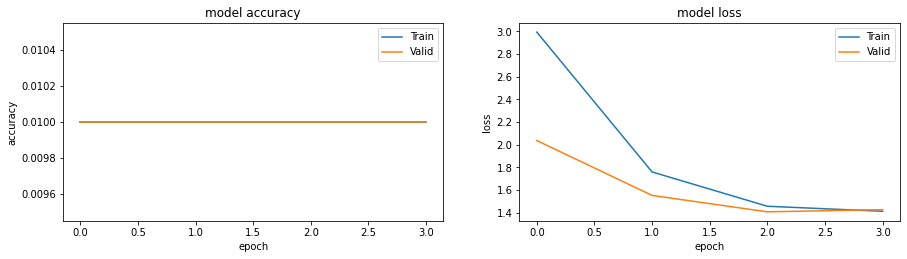

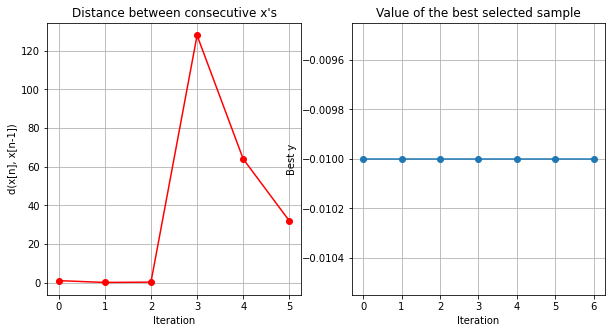

In [11]:
# define the kernel for the Bayesian surrogate model using the "radial basis function" (RBF)
kernel = GPy.kern.RBF(input_dim=1, variance=1.0, lengthscale=1.0)
# hyperparameter bounds
bounds = [
    {'name': 'units', 'type': 'discrete', 'domain': (32, 64, 128, 256, 512)}, 
    {'name': 'learning_rate', 'type': 'discrete', 'domain': (1e-3, 1e-4, 1e-5, 1e-6)}, 
    {'name': 'l2', 'type': 'discrete', 'domain': (1e-1, 1e-2, 1e-3)}, 
    {'name': 'activation', 'type': 'discrete', 'domain': (1, 2, 3, 4, 5)}, 
    {'name': 'rate', 'type': 'discrete', 'domain': (0.25, 0.5, 0.75)}]
# Note: 'activation' domain parameters (1, 2, 3, 4, 5, 6, 7) correspond to strings ('relu', 'elu', 'tanh','sigmoid', 'softplus', 'softsign', 'selu); dictionary defined in build_model()
# objective function for the model optimization:
def f(x):
  """objective function of the Bayesian surrogate model"""
  print()
  print("Hyperparameters:", x)
  # Retrieve 'accuracy' from the previously saved model
  try:
    previous_best_model = K.models.load_model('cifar10_best.h5')
    previous_evaluation = evaluate_model(previous_best_model)
  except Exception:
    previous_best_model = None
  model, lr_reduce, early_stop, checkpoint = build_model(
                                        units=int(x[:,0]),
                                        learning_rate=float(x[:,1]),
                                        l2=float(x[:,2]),
                                        activation=int(x[:,3]),
                                        rate=float(x[:,4]))
  history = fit_model(model, lr_reduce, early_stop, checkpoint)
  evaluation = evaluate_model(model)
  print()
  print("LOSS:\t{0} \t ACCURACY:\t{1}".format(evaluation[0],
  evaluation[1]))
  print(evaluation)
  print()
  # compare previous and current validation accuracies
  if not previous_best_model:
    K.models.save_model(model, 'cifar10_best.h5', overwrite=False,
    include_optimizer=True)
  if previous_best_model and evaluation[1] > previous_evaluation[1]:
    K.models.save_model(model, 'cifar10_best.h5', overwrite=True,
    include_optimizer=True)
  # Get the dictionary containing each metric and the loss for each epoch
  # history_dict = history.history
  # print(history_dict)
  plot = 0
  def plot_history(history):
    plt.figure(1, figsize = (15,8))
    plt.subplot(221)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Valid'])
    plt.subplot(222)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Valid'])
    plot = 0
    plt.savefig('Loss_Acc_'+str(plot)+'.pdf')
    plt.savefig('Loss_Acc_'+str(plot)+'.png')
    plot = plot + 1
    plt.show()
        
  # plot the model accuracy and loss results
  plot_history(history)
  # delete the instantiated models from memory and clear the session
  del model
  del previous_best_model
  K.backend.clear_session()
  return evaluation[1]
# Initializing X and Y, and adding noise (if need be)
# X_init = np.array([[int(16)]])
# Y_init = f(X_init)
# noise = 0.2
optimizer = BayesianOptimization(f=f,
                                 domain=bounds,
                                 model_type='GP',
                                 kernel=kernel,
                                 acquisition_type ='EI',
                                 acquisition_jitter = 0.01,
                                 # X=X_init,
                                 # Y=-Y_init,
                                 # noise_var = noise**2,
                                 exact_feval=False,
                                 normalize_Y=False,
                                 maximize=True,
                                 verbosity=False)
print()
print("=====================")
print("=====================")
print()
optimizer.run_optimization(max_iter=2, verbosity=False)
optimizer.plot_acquisition()
optimizer.plot_convergence()
optimizer.save_report('bayes_opt.txt')

In [12]:
# print optimized model
#activation_dict = {1: 'relu', 2: 'elu', 3: 'tanh'}
activation_dict = {1: 'relu', 2: 'elu', 3: 'tanh', 4: 'sigmoid', 5: 'softplus'}
print("""
Optimized Parameters:
\t{0}:\t{1}
\t{2}:\t{3}
\t{4}:\t{5}
\t{6}:\t{7}
\t{8}:\t{9}
""".format(bounds[0]["name"], optimizer.x_opt[0],
           bounds[1]["name"], optimizer.x_opt[1],
           bounds[2]["name"], optimizer.x_opt[2],
           bounds[3]["name"], activation_dict[optimizer.x_opt[3]],
           bounds[4]["name"], optimizer.x_opt[4]))
print("optimized accuracy: {0}".format(abs(optimizer.fx_opt)))


Optimized Parameters:
	units:	256.0
	learning_rate:	1e-05
	l2:	0.1
	activation:	tanh
	rate:	0.25

optimized accuracy: [0.01]


In [13]:
# reinstantiate the best model from saved file
best_model = K.models.load_model('cifar10_best.h5')
best_model.summary()
loss, acc = best_model.evaluate(features_valid, y_test)
print('Restored model, accuracy: {:5.2f}%'.format(100*acc))

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1920)]            0         
                                                                 
 dense (Dense)               (None, 256)               491776    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 492,033
Trainable params: 492,033
Non-trainable params: 0
_________________________________________________________________
313/313 [==============================] - 1s 3ms/step - loss: 18.7138 - accuracy: 0.0100
Restored model, accuracy:  1.00%


In [14]:
best_model.evaluate(features_valid, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 18.7138 - accuracy: 0.0100


[18.713834762573242, 0.009999999776482582]

In [15]:
data_path = 'bayes_opt.txt'
with open(data_path, 'r') as f:
  lines = f.read().split('\n')
for line in lines:
  print(line)

----------------------------- GPyOpt Report file -----------------------------------
GPyOpt Version 1.2.1
Date and time:               Tue Nov 29 08:08:09 2022
Optimization completed:      NO,7 samples collected.
Number initial samples:      5 
Tolerance:                   1e-08.
Optimization time:           90.35319352149963 seconds.

-------------------------------- Problem set up ------------------------------------
Problem name:                no_name
Problem dimension:           5
Number continuous variables  0
Number discrete variables    5
Number bandits               0
Noiseless evaluations:       False
Cost used:                   Used defined cost
Constrains:                  False

------------------------------ Optimization set up ---------------------------------
Normalized outputs:          False
Model type:                  GP
Model update interval:       1
Acquisition type:            EI
Acquisition optimizer:       lbfgs
Acquisition type:            EI
Acquisition opti

Configure the hyperparameters

In [16]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 20
image_size = 72  # We'll resize input images to this size
patch_size = 16  # Size of the patches to be extracted from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 2
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

 Use data augmentation

In [17]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

 Implement multilayer perceptron (MLP)

In [18]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [19]:
# Implement patch creation as a layer

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 72 X 72
Patch size: 16 X 16
Patches per image: 16
Elements per patch: 768


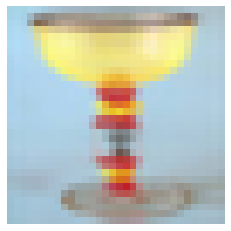

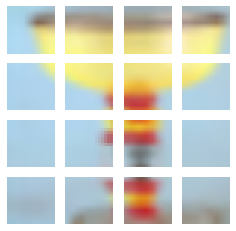

In [20]:

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [21]:
"""
The PatchEncoder layer will linearly transform a patch by projecting it into a vector of size projection_dim. In addition, it adds a learnable position embedding to the projected vector.

"""

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

Build the ViT model

In [22]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

Compile, train, and evaluate the model

In [23]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )
    model.summary()

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 data_augmentation (Sequential)  (None, 72, 72, 3)   7           ['input_1[0][0]']                
                                                                                                  
 patches_1 (Patches)            (None, None, 768)    0           ['data_augmentation[0][0]']      
                                                                                                  
 patch_encoder (PatchEncoder)   (None, 16, 64)       50240       ['patches_1[0][0]']              
                                                                                              